# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0lxggse7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0lxggse7
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=2b5fa6dcdea72b3f1e16a6200a6047373299e7b6a210da93fc11b1b2e2c518ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-0755hob3/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


<ipython-input-2-cc4b7f78b657>:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


Torch version: 2.5.1+cu121


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 165MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f2c582529e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

In [8]:
descriptions.keys()

dict_keys(['page', 'chelsea', 'astronaut', 'rocket', 'motorcycle_right', 'camera', 'horse', 'coffee'])

In [13]:
images_scikit = [skimage.data.page(), skimage.data.astronaut(), skimage.data.chelsea(), skimage.data.rocket(), skimage.data.stereo_motorcycle()[0], skimage.data.camera(), skimage.data.horse(), skimage.data.coffee()]

In [14]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

# for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
#     name = os.path.splitext(filename)[0]
#     if name not in descriptions:
#         continue

#     image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
for scikit_image, name in zip(images_scikit, descriptions.keys()):
    image = Image.fromarray(scikit_image).convert("RGB")
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{name}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [15]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [16]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [17]:
image_features.shape

torch.Size([8, 512])

In [18]:
text_features.shape

torch.Size([8, 512])

In [19]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

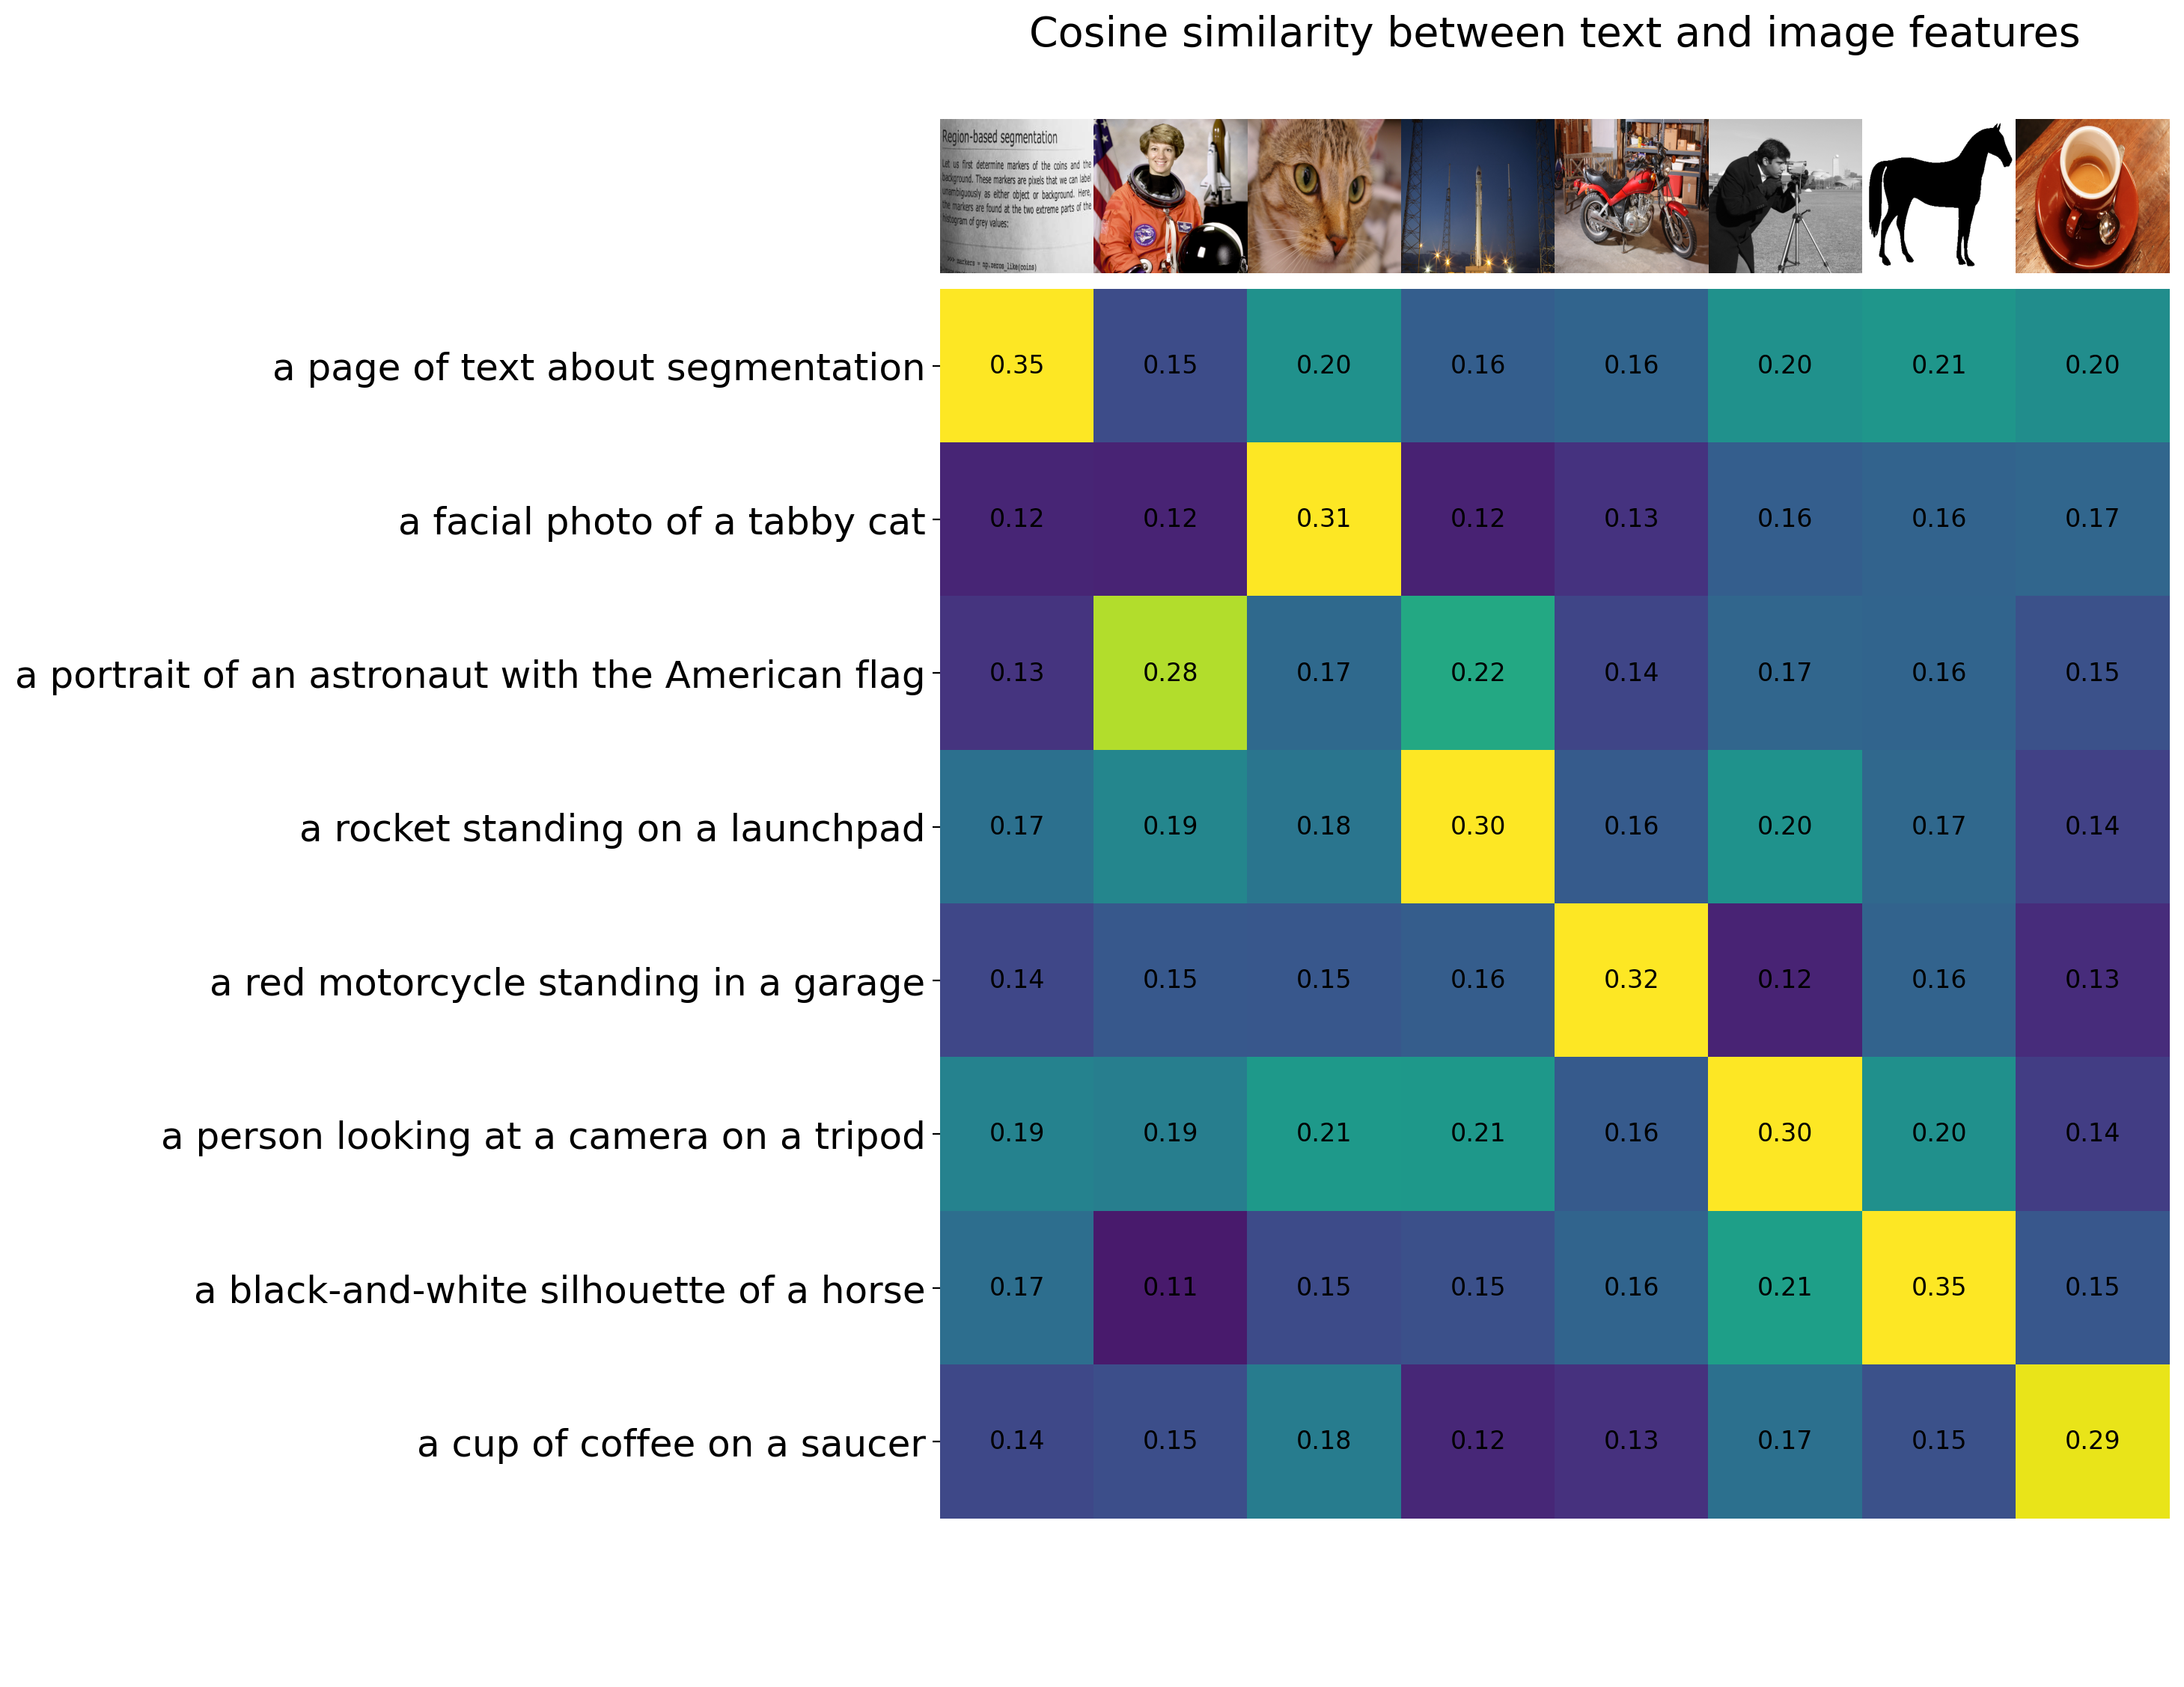

In [20]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [21]:
from torchvision.datasets import CIFAR100

In [22]:
train = CIFAR100(os.path.expanduser("~/.cache"), download=True, train=True, transform=preprocess)
test = CIFAR100(os.path.expanduser("~/.cache"), download=True, train=False, transform=preprocess)

100%|██████████| 169M/169M [00:03<00:00, 42.9MB/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache
Files already downloaded and verified


In [23]:
from tqdm import tqdm
from torch.utils.data import DataLoader

device = torch.device('cuda')

def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


In [24]:
train_features.shape, test_features.shape

((50000, 512), (10000, 512))

In [25]:
np.unique(train_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [26]:
import torch.nn as nn

class CifarClassifier(nn.Module):
    def __init__(self):
        super(CifarClassifier, self).__init__()
        self.fc1 = nn.Linear(512, 1024)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 100)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [27]:
model = CifarClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [28]:
class CifarEmbeddingsDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, labels):
        super(CifarEmbeddingsDataset, self).__init__()
        self.embeddings = embeddings
        self.labels = labels
    def __len__(self):
        return self.embeddings.shape[0]

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [29]:
train_dataset, test_dataset = CifarEmbeddingsDataset(train_features, train_labels), CifarEmbeddingsDataset(test_features, test_labels)

In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [31]:
n_epoch = 5
train_losses, val_losses = [], []
train_acc, val_acc = [], []
for epoch in range(n_epoch):
    model.train()
    losses = []
    acc = []
    for i, data in tqdm(enumerate(train_loader)):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs.to(device, dtype=torch.float32))
        assert not torch.isnan(outputs).sum()
        loss = loss_fn(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        acc.append(((labels.to(device) == outputs.argmax(dim=1)).sum() / len(labels)).cpu())

    train_losses.append(np.mean(losses))
    train_acc.append(np.mean(acc))

    model.eval()
    losses = []
    acc = []
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            inputs, labels = data

            outputs = model(inputs.to(device, dtype=torch.float32))

            loss = loss_fn(outputs, labels.to(device))

            losses.append(loss.item())
            acc.append(((labels.to(device) == outputs.argmax(dim=1)).sum() / len(labels)).cpu())

    val_losses.append(np.mean(losses))
    val_acc.append(np.mean(acc))

391it [00:01, 222.91it/s]
391it [00:01, 302.46it/s]
391it [00:01, 344.04it/s]
391it [00:01, 347.15it/s]
391it [00:01, 328.26it/s]


In [32]:
train_acc

[0.65987855, 0.77706605, 0.80201006, 0.8196931, 0.8351982]

In [33]:
val_acc

[0.77500015, 0.83750015, 0.75, 0.78749985, 0.83750015]

In [ ]:
train_losses

[0.4344569253342231,
 0.39046597610349243,
 0.35187080056618547,
 0.3056319698577037,
 0.26709061357981106]

In [ ]:
val_losses

[0.378738671541214,
 0.4130646586418152,
 0.2143247127532959,
 0.13044866919517517,
 0.23423349857330322]